运行环境：python 3  
使用包的版本：numpy 1.20.3, pandas 1.3.4, matplotlib 3.2.2, plotnine 0.8.0, sklearn 0.23.1  
复现步骤：依次运行以下代码即可

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from plotnine import *
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

In [2]:
data = pd.read_csv('admission.csv')
data.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [3]:
data['admit'] = pd.Categorical(data['admit'], ordered=True, categories=np.unique(data['admit']))

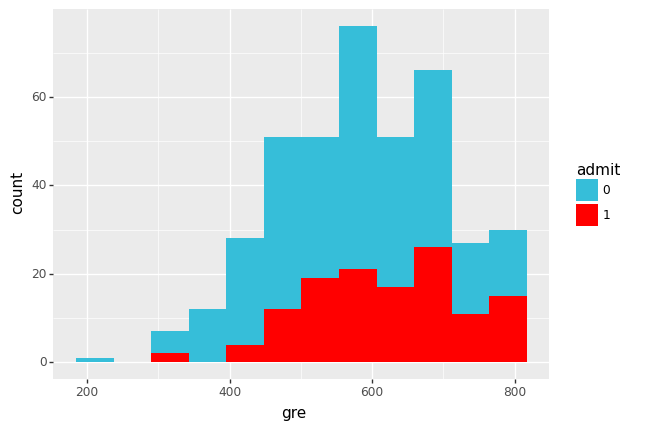

<ggplot: (134581936677)>

In [4]:
#数据分布直方图
(
    ggplot(data, aes(x='gre', y=after_stat('count'), fill='admit')) 
    + geom_histogram(bins=12)
     + scale_fill_manual(values=("#36BED9", "#FF0000"))
)

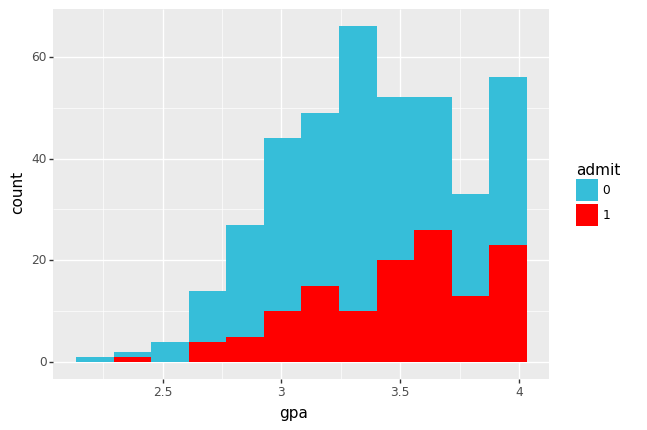

<ggplot: (134594992448)>

In [5]:
(
    ggplot(data, aes(x='gpa', y=after_stat('count'), fill='admit')) 
    + geom_histogram(bins=12)
    + scale_fill_manual(values=("#36BED9", "#FF0000"))
)

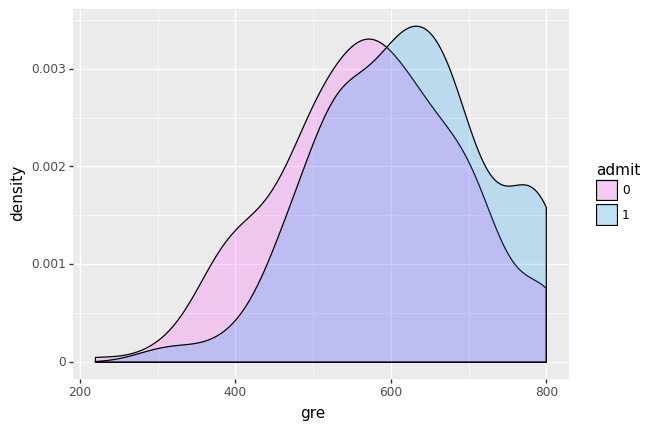

<ggplot: (134597196424)>

In [6]:
#核密度估计曲线图
(
    ggplot(data, aes(x='gre', fill='admit'))
    + geom_density(alpha=0.2)
    + scale_fill_manual(values=("#FF33FF", "#0099FF"))
)

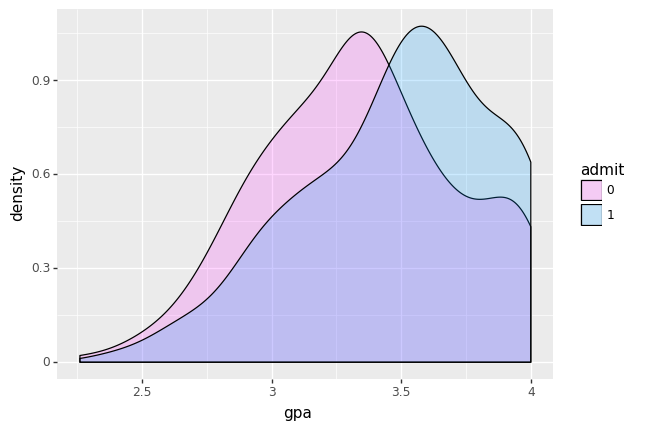

<ggplot: (134597151883)>

In [7]:
(
    ggplot(data, aes(x='gpa', fill='admit'))
    + geom_density(alpha=0.2)
    + scale_fill_manual(values=("#FF33FF", "#0099FF"))
)

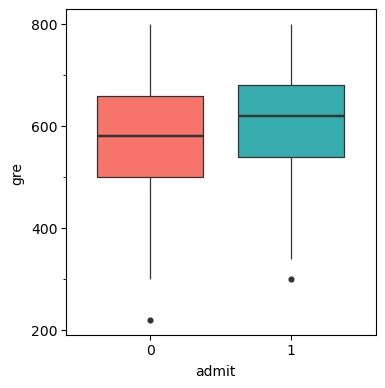

<ggplot: (134597214877)>

In [8]:
#箱型图
(
    ggplot(data,aes(x='admit',y="gre",fill="admit"))
    + geom_boxplot(show_legend=False)
    + scale_fill_hue(s = 0.90, l = 0.65, h=0.0417, color_space='husl')
    + theme_matplotlib()
    + theme(aspect_ratio =1.05,
       dpi=100,
       figure_size=(4,4))
)

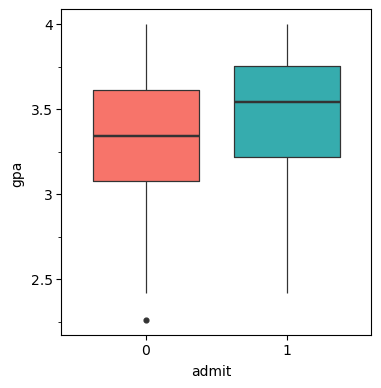

<ggplot: (134597179353)>

In [9]:
(
    ggplot(data,aes(x='admit',y="gpa",fill="admit"))
    + geom_boxplot(show_legend=False)
    + scale_fill_hue(s = 0.90, l = 0.65, h=0.0417, color_space='husl')
    + theme_matplotlib()
    + theme(aspect_ratio =1.05,
       dpi=100,
       figure_size=(4,4))
)

In [22]:
data1 = data.copy()
data1 = data1[['admit', 'rank']]
data1['n'] = 1
counts = data1.groupby(['admit', 'rank']).sum()
counts2 = data1.groupby('admit').count()
counts2.rename(columns={'rank': 'total'}, inplace=True)
count = pd.merge(counts,counts2.iloc[:,0], left_index=True, right_index=True)
count['percent'] = count['n'] / count['total']
count = count.reset_index()
count

,admit,rank,n,total,percent
0,0,1,28,273,0.102564
1,0,2,97,273,0.355311
2,0,3,93,273,0.340659
3,0,4,55,273,0.201465
4,1,1,33,127,0.259843
5,1,2,54,127,0.425197
6,1,3,28,127,0.220472
7,1,4,12,127,0.094488


In [23]:
count['rank'] = pd.Categorical(count['rank'], ordered=True, categories=np.unique(count['rank']))

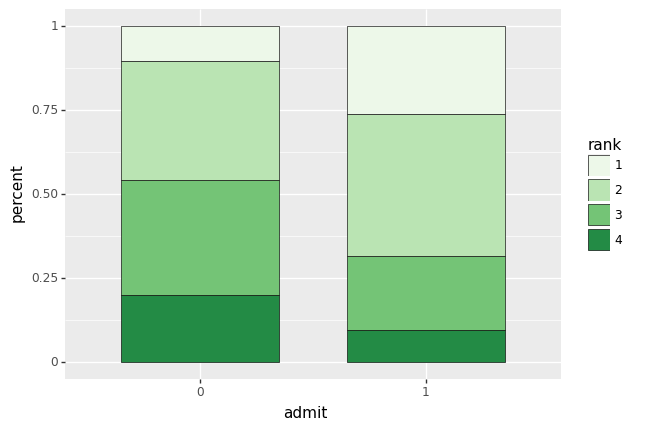

<ggplot: (134598766195)>

In [24]:
#百分比堆积柱状图
(
    ggplot(count, aes(x='admit', y='percent', fill='rank'))
    + geom_col(stat='identity', color='k', position='fill', width=0.7, size=0.25)
    + scale_fill_brewer(type='seq',palette='Greens')
)

In [10]:
class Data:    
    def __init__(self, df, target_col=-1): #默认目标变量在最后一列
        try:
            y_ = df.columns[target_col]
        except AttributeError: #若输入的数据不是数据框，则将其转化为数据框，防止异常导致程序终止
            df = pd.DataFrame(df)
        except IndexError:
            raise IndexError('Index out of range!') from None
        self.X = df.drop(df.columns[target_col], axis=1)
        self.y = df.iloc[:, target_col]
    
    def get_rows(self, row_indices): #获取样本的某几行，返回值仍是一个Data类对象
        try:
            X1 = self.X.iloc[row_indices, :]
            y1 = self.y.iloc[row_indices]
            return Data(X1.join(y1))
        except IndexError:
            raise IndexError('Index out of range!') from None
    
    def get_cols(self, col_indices): #获取自变量的某几列，返回一个数据框
        try:
            X2 = self.X.iloc[:, col_incides]
            return X2
        except IndexError:
            raise IndexError('Index out of range!') from None
    
    def scaled(self, target=False): #中心标准化，target表示目标变量是否参加中心标准化，该方法返回一个Data类对象
        X_scale = self.X
        if taregt:
            X_scale = self.X.join(self.y)
        X_scale = (X_scale - X_scale.mean()) / X_scale.std()
        if not target:
            X_scale = pd.merge(X_scale, self.y, left_index=True, right_index=True)
        return Data(X_scale)
    
    def dummy(self, columns=None, prefix=None): #将列名为columns的列对应的变量转化成哑变量
        df_dummy = pd.get_dummies(self.X, columns=columns, prefix=prefix)
        return Data(df_dummy.join(self.y))
    
    def split_train_test(self, test_size=0.25, random_state=None): #生成训练集和测试集
        try:
            Xtrain, Xtest, ytrain, ytest = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)
            df_train = Data(Xtrain.join(ytrain))
            df_test = Data(Xtest.join(ytest))
            return df_train, df_test
        except ValueError:
            raise
    
    def logistic_regression(self, fit_intercept=True, class_weight=None): #搭建逻辑回归模型
        return linear_model.LogisticRegression(fit_intercept=fit_intercept, class_weight=class_weight).fit(self.X, self.y)
    
    def randomforest(self, n_estimators=100, random_state=None, max_features='auto', min_samples_leaf=1, max_depth=None, class_weight=None): #搭建随机森林模型
        return RandomForestClassifier(n_estimators=n_estimators, random_state=random_state, max_features=max_features, min_samples_leaf=min_samples_leaf, max_depth=max_depth, class_weight=class_weight).fit(self.X, self.y)
    
    def feature_selection_by_rf(self, n_features_to_select=None, n_estimators=100, random_state=None): #通过随机森林进行特征选择
        estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        res = RFE(estimator, n_features_to_select=n_features_to_select)
        return res.fit(self.X, self.y)
    
    def plot_feature_importance(self, figsize=(8,6), n_features_to_select=None, n_estimators=100, random_state=None): #绘制变量重要性图
        estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
        rfc = estimator.fit(self.X, self.y)
        features = self.X.columns
        importances = rfc.feature_importances_
        indices = np.argsort(importances)
        plt.figure(figsize=figsize)
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), importances[indices], color='b', align='center')
        plt.yticks(range(len(indices)), features[indices])
        plt.xlabel('Relative Importance')
    
    def calculate_accuracy(self, fit_model): #输出模型预测混淆矩阵及准确率
        y_pred = fit_model.predict(self.X)
        confu_matrix = confusion_matrix(self.y, y_pred)
        print(confu_matrix)
        print('模型预测的准确率为：%s%s'% (accuracy_score(self.y, y_pred) * 100, '%'))
        
    def plot_roc(self, fit_model, model, figsize=(6,6), color=['darkorange', 'blue'], lw=2, label_size=14, title_size=18, legend_size=18, save=False): #绘制ROC曲线图
        if model == 'lr':
            y_score = fit_model.decision_function(self.X)
            title = 'ROC curve for logistic regression'
        if model == 'rf':
            y_score = fit_model.predict_proba(self.X)[:, 1]
            title = 'ROC curve for randomforest'
        fpr, tpr, threshold = roc_curve(self.y, y_score)
        auc_value = auc(fpr, tpr)
        plt.figure(figsize=figsize)
        plt.plot(fpr, tpr, color=color[0], lw=lw, label='AUC: %0.3f' % auc_value)
        plt.plot([0, 1], [0, 1], color=color[1], lw=lw, linestyle='--')
        plt.xlim([-0.01, 1.01])
        plt.ylim([-0.01, 1.01])
        #plt.yticks(fontsize=10)
        #plt.xticks(fontsize=10)
        plt.xlabel('1 - Sepcificity', size=label_size)
        plt.ylabel('Sensitivity', size=label_size)
        plt.title(title, size=title_size)
        plt.legend(loc='lower right', fontsize=legend_size)
        if save:
            plt.savefig('roc_curve.png')
        plt.show()

In [11]:
#查看总体样本比例
data.admit.value_counts()

0    273
1    127
Name: admit, dtype: int64

In [12]:
df = Data(data, target_col=0)

#将rank转化为哑变量rank_1,rank_2,rank_3,rank_4
df_dummy = df.dummy(['rank'], prefix='rank')
df_dummy.X = df_dummy.X.iloc[:, :(-1)] #由于四个哑变量的线性关系，去掉rank_4
df_dummy.X

,gre,gpa,rank_1,rank_2,rank_3
0,380,3.61,0,0,1
1,660,3.67,0,0,1
2,800,4.00,1,0,0
3,640,3.19,0,0,0
4,520,2.93,0,0,0
...,...,...,...,...,...
395,620,4.00,0,1,0
396,560,3.04,0,0,1
397,460,2.63,0,1,0
398,700,3.65,0,1,0


In [13]:
#基于随机森林进行变量筛选
df_dummy.feature_selection_by_rf().ranking_ #输出变量重要性排序

array([1, 1, 2, 3, 4])

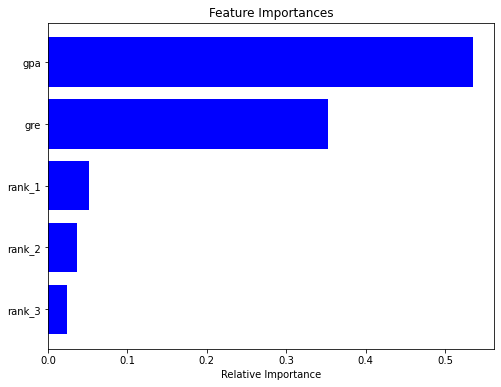

In [14]:
#画出重要性图
df_dummy.plot_feature_importance()

In [15]:
#变量rank_3重要性最低，故剔除此变量
df_dummy.X = df_dummy.X.iloc[:, :4]
mydata = df_dummy

In [16]:
#随机抽取30%的样本作为测试集，其余作为训练集
df_train, df_test = mydata.split_train_test(test_size=0.3, random_state=2021)
df_test.X #测试集样本

,gre,gpa,rank_1,rank_2
243,620,3.22,0,1
124,720,3.88,0,0
342,500,3.95,0,0
129,460,3.15,0,0
242,680,2.96,0,0
...,...,...,...,...
255,640,3.35,0,0
393,620,3.75,0,1
339,660,3.47,0,0
204,600,3.89,1,0


In [17]:
#查看测试集样本比例
df_test.y.value_counts()

0    85
1    35
Name: admit, dtype: int64

In [18]:
#建立逻辑回归模型
fit_lr = df_train.logistic_regression(class_weight={0: 1, 1: 1.7})
fit_lr.coef_

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([[0.00192686, 0.46906643, 1.01959748, 0.63884146]])

In [19]:
fit_lr.intercept_

array([-3.33737269])

In [20]:
#预测
df_test.calculate_accuracy(fit_lr)

[[62 23]
 [11 24]]
模型预测的准确率为：71.66666666666667%


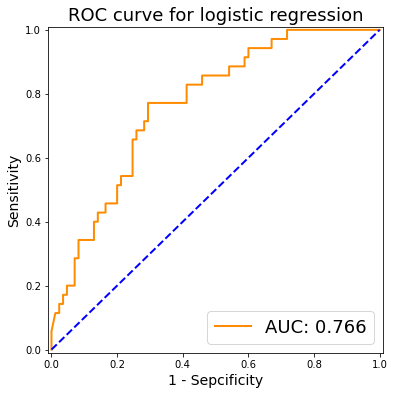

In [21]:
#绘制ROC曲线
df_test.plot_roc(fit_lr, model='lr', save=False)